# Effective pedagogies for teaching data science

Mike Gelbart 

UBC Jupyter Days 2020

In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

import re

In [4]:
# To fix later, don't want to break the Jupyter Book
try:
    import graphviz
    graphviz_imported = True
except ImportError:
    graphviz_imported = False
    
def display_tree(df, tree):
    """ For binary classification only """
    if not graphviz_imported:
        return
    dot = export_graphviz(tree, out_file=None, feature_names=df.columns[:-1], class_names=tree.classes_,impurity=False)
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])(\\\\nclass = [A-Za-z0-9]+)', '', dot)
    dot = re.sub(     '(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n', '', dot)
    return graphviz.Source(dot)

Note to self: run these imports ^

In this session I will discuss a few tips for teaching data science, especially with Jupyter notebooks:

- Real-time collaborative documents (10 min)
- [Live coding](https://en.wikipedia.org/wiki/Live_coding) with Jupyter (5 min)
- [Problem-based learning](https://www.queensu.ca/ctl/teaching-support/instructional-strategies/problem-based-learning) (20 min)
- Break (5-10 min)
- Sample activity: decision trees (20 min)
- My implementation of [think-pair-share](https://en.wikipedia.org/wiki/Think-pair-share) (5-10 min, time-permitting)
- Q&A (remaining time)

## About me

- Assistant Professor of Teaching, UBC Computer Science
- Option Co-Director, UBC Master of Data Science program
- Background in machine learning

## Real-time documents (10 min)

- Especially great for online teaching. 
- Here is a [Google Doc](https://docs.google.com/document/d/1I8uHzqTXzm4KlAsupKCsO_adoXslX-fCvS4-DW-5yws/edit?usp=sharing) for today.
- Let's start by completing the Introductions and Activity 1. 
- This tool pairs well with Jupyter.
  - For example, I had students create visualizations and screenshot them in the document.

## Live coding in Jupyter (5 min)

- I'm a big fan of live experiments.
- I don't do much "live coding" but I do "live execution".
- You've probably seen a lot of this but here's my version:

<div><img src="img/regularization_ppt.png" width="500"/></div>

<br><br>vs.<br><br>

<div><img src="img/regularization_ipynb.png" width="750"/></div>

Main ideas:

- No "magic".
- Cultivates an atmosphere of experimentation.

## Problem-based learning (20 min)

My CPSC 340 syllabus:

- Day 1: Decision Trees
- Day 2: $k$-nearest neighbours
- etc.

My CPSC 330 syllabus:

- Week 1: census dataset
- Week 2: houseing dataset
- etc.

Jupyter facilitates this "problem-based learning" really well.

#### Example: Canadian cheese dataset

Below I will show a pretend lesson using the [Canadian Cheese Directory dataset](https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b) from Agriculture and Agri-Food Canada. This data is distributed under the [Canadian Open Government License](https://open.canada.ca/en/open-government-licence-canada) so I have bundled it with this Jupyterbook.

We will be predicting `FatContentPercent` based on the other features.

In [26]:
df = pd.read_csv("data/canadianCheeseDirectory.csv", index_col=0)

We will be predicting `FatContentPercent`, which is not available for all the cheeses, so I will first filter out those where this is not available:

In [27]:
df = df.dropna(subset=['FatContentPercent'])

In [28]:
df_train, df_test = train_test_split(df, random_state=123) 

In [29]:
y_train = df_train['FatContentPercent']

In [30]:
lm = Ridge()

In [31]:
# lm.fit(df_train, y_train)

ValueError: could not convert string to float: 'Traditional Feta'

- Now we run into our first error. 
- I like to leave these in.
  - However, they cause problems when running all cells (or building a Jupyter Book?).
  - Fixing this issue seems to be [in progress](https://github.com/jupyterlab/jupyterlab/issues/2412).
- Not all the "problems" we encounter are Python errors. 
- Problem types:
  - Python error
  - Poor model accuracy
  - Prohibitively slow code
  - Problems you didn't know you had (the worst kind!), especially around train/test contamination
  - I don't know where to start

Problem: non-numeric data.

In [32]:
df_train.head()

,CheeseNameEn,CheeseNameFr,ManufacturerNameEn,ManufacturerNameFr,ManufacturerProvCode,ManufacturingTypeEn,ManufacturingTypeFr,WebSiteEn,WebSiteFr,FatContentPercent,...,Organic,CategoryTypeEn,CategoryTypeFr,MilkTypeEn,MilkTypeFr,MilkTreatmentTypeEn,MilkTreatmentTypeFr,RindTypeEn,RindTypeFr,LastUpdateDate
CheeseId,,,,,,,,,,,,,,,,,,,,,
1432,NaN,Chèvre des Alpes BIO,Damafro,Damafro,QC,Industrial,Industrielle,http://www.damafro.ca/en/home.html,http://www.damafro.ca,22.0,...,1,Fresh Cheese,Pâte fraîche,Goat,Chèvre,Pasteurized,Pasteurisé,No Rind,Sans croûte,2016-02-03
2281,NaN,Frère Chasseur (Le),NaN,Fromagerie Au Gré des Champs,QC,Artisan,Artisanale,NaN,http://www.augredeschamps.com,35.0,...,1,Firm Cheese,Pâte ferme,Cow,Vache,Raw Milk,Lait cru,NaN,NaN,2016-02-03
1908,NaN,Mon précieux,NaN,Fromagerie Couland,QC,Artisan,Artisanale,NaN,NaN,22.0,...,0,Fresh Cheese,Pâte fraîche,Goat,Chèvre,Pasteurized,Pasteurisé,No Rind,Sans croûte,2016-02-03
2224,NaN,Tomme de Brebis de Charlevoix,NaN,Maison d'affinage Maurice Dufour (La),QC,Artisan,Artisanale,NaN,http://www.fromagefin.com,33.0,...,0,Firm Cheese,Pâte ferme,Ewe,Brebis,NaN,NaN,Washed Rind,Croûte lavée,2016-02-03
2007,NaN,Cheddar Littoral,NaN,Fromagerie Ferme du littoral,QC,Farmstead,Fermière,NaN,NaN,30.0,...,0,Firm Cheese,Pâte ferme,Cow,Vache,Pasteurized,Pasteurisé,No Rind,Sans croûte,2016-02-03


Now perhaps the lesson goes to encoding categorical variables...

In [33]:
df["ManufacturerName"] = df["ManufacturerNameEn"].fillna(df["ManufacturerNameFr"])
df = df.drop(columns=["ManufacturerNameEn", "ManufacturerNameFr"])
df["CheeseName"] = df["CheeseNameEn"].fillna(df["CheeseNameFr"])
df = df.drop(columns=["CheeseNameEn", "CheeseNameFr"])
df = df.drop(columns=[col for col in df.columns if col.endswith("Fr")])
df_train, df_test = train_test_split(df, random_state=123)

In [34]:
numeric_features = ['MoisturePercent']
categorical_features = ['ManufacturerProvCode', 'ManufacturingTypeEn', 'Organic', 'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn', 'RindTypeEn', 'ManufacturerName']
text_features = ['CheeseName', 'FlavourEn', 'CharacteristicsEn']
drop_features = ['WebSiteEn', 'ParticularitiesEn', 'RipeningEn', 'LastUpdateDate']
target_column = 'FatContentPercent'
assert set(numeric_features + categorical_features + text_features + drop_features + [target_column]) == set(df_train.columns)

In [35]:
y_train = df_train[target_column]
y_test = df_test[target_column]

- Note how I've minimized some of the code cells.
- In class, I would show more of them.
- But not necessarily all, if they are beyond the scope, not relevant, or old news.

Now to the key code:

In [36]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(sparse=False))
])

# Fit a separate CountVectorizer for each of the text columns.
# Need to convert the resulting sparse matrices to dense separately.
text_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('tolist', FunctionTransformer(lambda x: x.ravel(), validate=False)),
    ('countvec', CountVectorizer(max_features=10, stop_words='english')),
    ('todense', FunctionTransformer(lambda x: x.toarray(), validate=False))
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features)
] + [(f, text_transformer, [f]) for f in text_features])

In [37]:
preprocessor.fit(df_train);

In [38]:
def get_column_names(preprocessor):
    """
    Gets the feature names from a preprocessor.
    This entails looking at the OHE feature names and also
    the words used by the CountVectorizers.
    
    Arguments
    ---------
    preprocessor: ColumnTransformer
        A fit preprocessor following the specific format above.
    
    Returns
    -------
    list
        A list of column names.
    """
    ohe_feature_names = list(preprocessor.named_transformers_['categorical'].named_steps['onehot'].get_feature_names(categorical_features))
    text_feature_names = [f + "_" + word for f in text_features for word in preprocessor.named_transformers_[f].named_steps['countvec'].get_feature_names()]
    return numeric_features + ohe_feature_names + text_feature_names

In [39]:
new_columns = get_column_names(preprocessor)
    
df_train_enc = pd.DataFrame(preprocessor.transform(df_train), index=df_train.index, columns=new_columns)
df_train_enc.head()

,MoisturePercent,ManufacturerProvCode_AB,ManufacturerProvCode_BC,ManufacturerProvCode_MB,ManufacturerProvCode_NB,ManufacturerProvCode_NL,ManufacturerProvCode_NS,ManufacturerProvCode_ON,ManufacturerProvCode_PE,ManufacturerProvCode_QC,...,CharacteristicsEn_cheese,CharacteristicsEn_colored,CharacteristicsEn_creamy,CharacteristicsEn_interior,CharacteristicsEn_pressed,CharacteristicsEn_rind,CharacteristicsEn_ripened,CharacteristicsEn_smooth,CharacteristicsEn_texture,CharacteristicsEn_white
CheeseId,,,,,,,,,,,,,,,,,,,,,
1432,1.127656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2281,-1.459684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908,2.266086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2224,-1.459684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007,-0.528242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Awesome, we've got everything into numeric data!
- Now let's train a model:

In [41]:
pipeline_dummy = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())])

In [42]:
# scores_dummy = cross_validate(pipeline_dummy, df_train, y_train, cv=5, return_train_score=True)
# pd.DataFrame(scores_dummy)[["train_score", "test_score"]].mean()

ValueError: Found unknown categories ['NL'] in column 0 during transform

Oh no, another error - what is going on this time? Etc.

Going back to the problem types:
    
- Python error
- Poor model accuracy
- Prohibitively slow code
- Problems you didn't know you had (the worst kind!), especially around train/test contamination

Most of the topics / learning outcomes in the course fit into one of these categories. 

| Topic  | Problem  |
|--------|----------|
| One-hot encoding | Python error |
| Overfitting | Poor model accuracy
| Fancy models, e.g. CatBoost | Poor model accuracy |
| Feature importances, e.g. SHAP | Lack of interpretability | 
| Pipelines | Problems you didn't know you had, hard-to-maintain code |
| Cross-validation | Poor model accuracy, problems you didn't know you had |
| Survival analysis | Problems you didn't know you had |
| Pre-trained deep networks | Don't know where to start |

etc.

## Another quick activity before the break

- Let's generate a dataset for another supervised learning problem: predicting whether someone has seen the movie _The Lion King_.
- Let's head back to the [Google Doc](https://docs.google.com/document/d/1I8uHzqTXzm4KlAsupKCsO_adoXslX-fCvS4-DW-5yws/edit?usp=sharing).

## Break (5-10 min)

## Sample activity: decision trees (20 min)

- Basic idea: ask a bunch of yes/no questions until you end up at a prediction.
- E.g. 
  - If you are scared of lions, predict "No"
  - Otherwise, if you've seen a movie in the last 2 weeks, predict "Yes"
  - Otherwise, if you'd pay > \\$5 for a movie, predict "Yes"
  - Otherwise, predict "No"

- This "series of questions" approach can be drawn as a tree:

```
            Are you scared of lions?
            /          \
           / True       \  False
          /              \
         No           Have you seen a movie in the last 2 weeks?
                        /      \
                  True /        \ False
                      /          \ 
                    Yes         Would you pay more than $5 for a movie?  
                                 /           \
                                / True        \ False
                               /               \
                              Yes              No
```

- The decision tree algorithm automatically learns a tree like this, based on the data set!
  - We don't have time to go through how the algorithm works.
  - But it's worth noting that it support two types of inputs:

1. Categorical (e.g., Yes/No or more options)
2. Numeric (a number)

In the numeric case, the decision tree algorithm also picks the _threshold_ (\\$5 in this case)

- Let's apply a decision tree to our _The Lion King_ dataset.


In [43]:
lion_king = pd.read_csv("data/lionking_test.csv")
lion_king.tail()

,Are you scared of lions?,Have you watched a movie in the last 2 weeks?,How much would you pay to see a good movie? (in $),Have you seen the movie The Lion King?
0,No,No,10,Yes
1,Yes,Yes,10,Yes
2,Yes,No,10,No
3,No,No,0,No


In [44]:
lion_king.loc[:,lion_king.columns[:2]] = lion_king.loc[:,lion_king.columns[:2]] == "No"
# Note on the above: Encoding "No" as 1 and "Yes" as 0 because sklearn uses <= 0.5; this makes the tree diagrams more readable.

In [45]:
tree = DecisionTreeClassifier(max_depth=1).fit(lion_king.iloc[:,:-1], lion_king.iloc[:,-1])

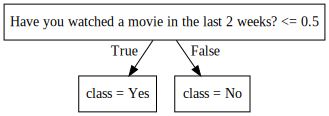

In [46]:
display_tree(lion_king, tree)

In [47]:
lion_king.iloc[:,-1].value_counts()

Yes    2
No     2
Name: Have you seen the movie The Lion King?, dtype: int64

In [48]:
21/30

0.7

In [49]:
tree.score(lion_king.iloc[:,:-1], lion_king.iloc[:,-1])

0.75

Now, let's make this more interesting by increasing the **depth** of the tree. 

In [50]:
tree2 = DecisionTreeClassifier(max_depth=3).fit(lion_king.iloc[:,:-1], lion_king.iloc[:,-1])

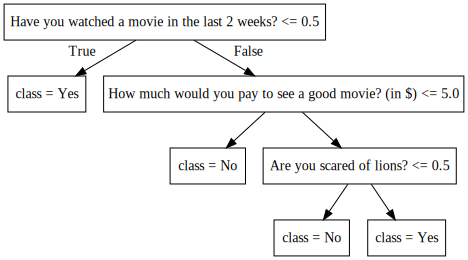

In [51]:
display_tree(lion_king, tree2)

Please ignore the `<= 0.5` above, it's a detail we don't need to get into here.

In [52]:
tree2.score(lion_king.iloc[:,:-1], lion_king.iloc[:,-1])

1.0

In [53]:
tree_max = DecisionTreeClassifier(max_depth=100).fit(lion_king.iloc[:,:-1], lion_king.iloc[:,-1])

In [54]:
tree_max.score(lion_king.iloc[:,:-1], lion_king.iloc[:,-1])

1.0

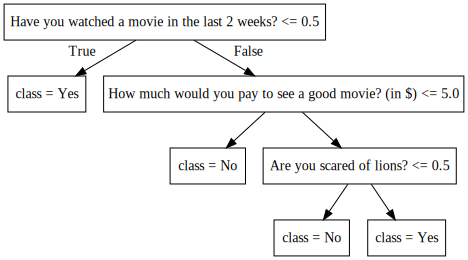

In [55]:
display_tree(lion_king, tree_max)

## Think-pair-share (5-10 min, time permitting)

- Think-pair-share is an evidence-based teaching approach.
- The idea is for students to learn from each other.
- I find it works great in DS teaching.
- Example:

#### Cross-validation true/false questions

1. $k$-fold cross validation calls `fit` $k$ times and `predict` $k$ times.
2. The goal of cross-validation is to obtain a better estimate of test error than just using a single validation set.
3. The main disadvantage of using a large $k$ in cross-validation is running time.
4. $2$-fold cross validation is the same thing as using a validation set that's 50% the size of your training set.

I would usually allocate 10-15 min for the above.

Details on my approach:

- Easier to come up with answers because not limited to 1 True, 3-4 False
- Can use hand-raising
- Gives more flexibility to have ambiguous questions without messing up the rest
- Try to make one of the earlier ones true (1 or 2), in general slightly more true, since this encourages participation.
- "My answer" instead of "the answer"
- Often, when the majority disagreed with me, we discovered an ambiguity or catch
- I don't write down answers


## Q&A (15 min)